In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from glob import glob
from ridgereliability.plots import river_reliability_diagram, confidence_reliability_diagram, class_wise_river_reliability_diagram
from ridgereliability import metrics

In [2]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(30, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(13, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(120, activation='relu'))
model.add(tf.keras.layers.Dense(86, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=50,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
callbacks = [early_stopping]

model.fit(x_train, y_train,
          batch_size=32, epochs=10,
         validation_data=(x_test, y_test),
         callbacks=callbacks)

In [ ]:
model.save('models/cifar10_lenet.h5')

In [4]:
model = tf.keras.models.load_model('models/cifar10_lenet.h5')
z_test = model.predict(x_test, batch_size=128, verbose=1)

79/79 [==============================] - 1s 14ms/step


In [5]:
y_probs = z_test.max(axis=1)
y_probs_full = z_test
y_preds = z_test.argmax(axis=1)
y_true = y_test.argmax(axis=1)

In [6]:
acc = (y_preds == y_true).mean()
print(f'Accuracy: {acc}')

ece = metrics.ece(y_probs, y_preds, y_true)
print(f'ECE     : {ece}')

peace = metrics.peace(y_probs, y_preds, y_true)
print(f'PEACE   : {peace}')

Accuracy: 0.6267
ECE     : 0.06896283069550993
PEACE   : 0.09022169257942489


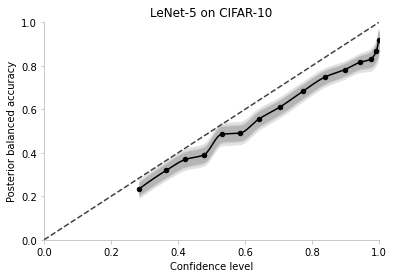

In [7]:
ax = plt.gca()
plt.title('LeNet-5 on CIFAR-10')
river_reliability_diagram(y_probs, y_preds, y_true, ax, bins="count")
plt.savefig('plots/lenet.pdf')
plt.show()

In [8]:
cw_ece = metrics.class_wise_error(y_probs_full, y_preds, y_true, base_error=metrics.ece)
print(f'CW-ECE  : {cw_ece}')

cw_peace = metrics.class_wise_error(y_probs_full, y_preds, y_true, base_error=metrics.peace)
print(f'CW-PEACE: {cw_peace}')

CW-ECE  : 0.02811348430052401
CW-PEACE: 0.1703070783732524


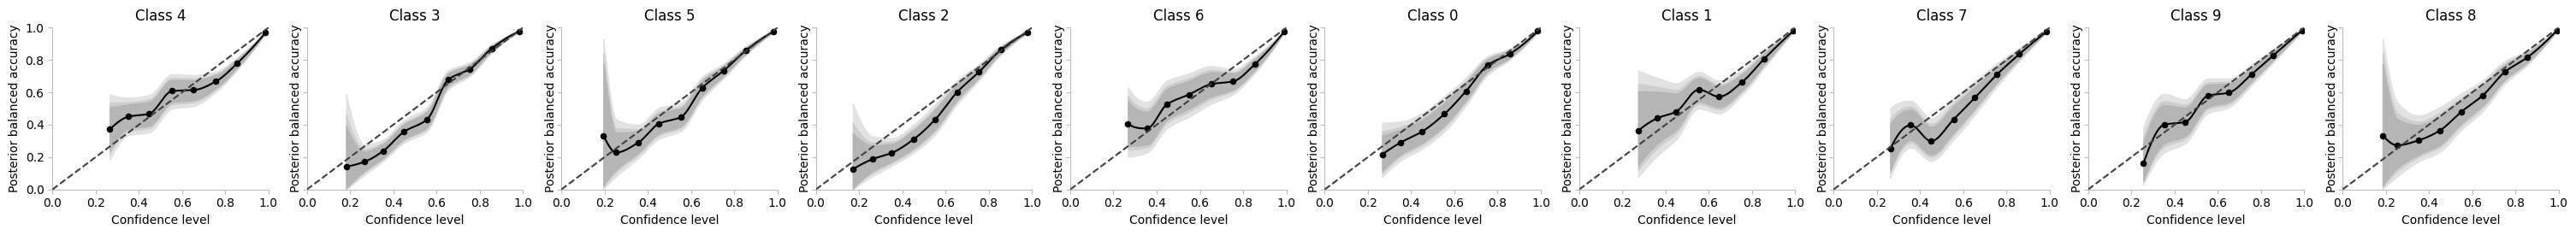

In [12]:
axes = class_wise_posterior_reliability_diagram(y_probs_full, y_preds, y_true, bins=10, metric=metrics.peace)
plt.savefig('plots/lenet_cw.pdf')
plt.show()

In [ ]:
temperature = tf.Variable(1.0)
model.layers[-1].activation = lambda x: tf.keras.activations.softmax(x / temperature)
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [ ]:
temps = np.linspace(1, 2, 100)
size = 1000
x_batch, y_batch = shuffle(x_train, y_train)
x_batch, y_batch = x_batch[:size], y_batch[:size]
best_ece, best_temp = np.inf, 0
for temp in tqdm(temps):
    temperature.assign(temp)
    z_test = model.predict(x_test, batch_size=128, verbose=0)
    y_probs = z_test.max(axis=1)
    y_preds = z_test.argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    ece = metrics.ece(y_probs, y_preds, y_true)
    if ece < best_ece:
        best_ece = ece
        best_temp = temp
print(best_temp)

In [ ]:
temperature.assign(best_temp)
z_test = model.predict(x_test, batch_size=128, verbose=1)
y_probs = z_test.max(axis=1)
y_preds = z_test.argmax(axis=1)
y_true = y_test.argmax(axis=1)

acc = (y_preds == y_true).mean()
print(f'Accuracy: {acc}')

ece = metrics.ece(y_probs, y_preds, y_true)
print(f'ECE     : {ece}')

peace = metrics.peace(y_probs, y_preds, y_true)
print(f'PEACE   : {peace}')

ax = plt.gca()
posterior_reliability_diagram(y_probs, y_preds, y_true, ax, bins=10)
plt.savefig('plots/lenet_scaled.pdf')
plt.show()

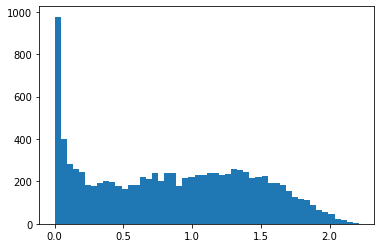

In [5]:
entropies = -np.sum(z_test * np.log(z_test), axis=1)
plt.hist(entropies, bins=50)
plt.show()